In [ ]:
!pip install transformers huggingface_hub PyPDF2 gensim matplotlib wordcloud seaborn pyLDAvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import PyPDF2

# Path to your PDF folder in Google Drive
pdf_folder_path = '/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/'

def extract_text_from_pdfs(pdf_folder_path):
    pdf_texts = []

    # Loop through all files in the directory
    for filename in os.listdir(pdf_folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(pdf_folder_path, filename)
            with open(file_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                text = ''
                for page in range(len(reader.pages)):
                    text += reader.pages[page].extract_text()
                pdf_texts.append(text)

    return pdf_texts

# Extract text from all PDFs in the folder
pdf_texts = extract_text_from_pdfs(pdf_folder_path)


In [ ]:
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

def preprocess_text(text):
    return [word for word in simple_preprocess(text) if word not in stop_words]

# Preprocess all PDF texts
processed_texts = [preprocess_text(text) for text in pdf_texts]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from gensim import corpora

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]


In [ ]:
from gensim.models.ldamodel import LdaModel

# Create LDA model (adjust the number of topics)
lda_model = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.027*"tunnel" + 0.025*"tn" + 0.016*"nodes" + 0.012*"protocol" + 0.011*"node" + 0.010*"communication" + 0.008*"tunnels" + 0.008*"message" + 0.007*"using" + 0.006*"number"')
(1, '0.001*"network" + 0.001*"tor" + 0.001*"data" + 0.001*"anonymity" + 0.001*"web" + 0.000*"number" + 0.000*"security" + 0.000*"peers" + 0.000*"hidden" + 0.000*"based"')
(2, '0.014*"attacks" + 0.013*"anonymity" + 0.013*"tor" + 0.010*"security" + 0.008*"attack" + 0.008*"networks" + 0.007*"network" + 0.007*"pp" + 0.005*"adversary" + 0.005*"protocol"')
(3, '0.051*"wkh" + 0.026*"ri" + 0.026*"dqg" + 0.023*"lv" + 0.021*"lq" + 0.013*"wr" + 0.012*"kh" + 0.010*"rq" + 0.009*"iru" + 0.008*"fodvvlilfdwlrq"')
(4, '0.015*"network" + 0.012*"tunnel" + 0.011*"tunnels" + 0.009*"data" + 0.008*"communication" + 0.007*"nodes" + 0.007*"anonymity" + 0.007*"peer" + 0.007*"traffic" + 0.006*"networks"')
(5, '0.016*"tor" + 0.011*"network" + 0.008*"trafﬁc" + 0.007*"data" + 0.005*"used" + 0.005*"based" + 0.004*"features" + 0.004*"set" + 0

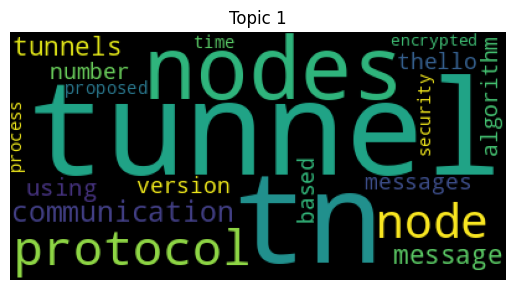

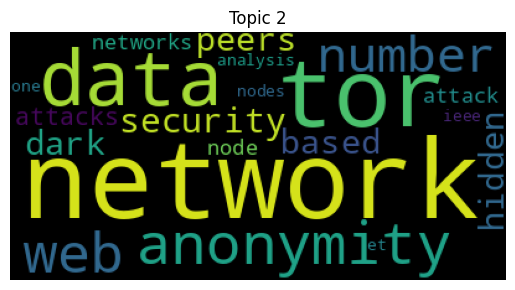

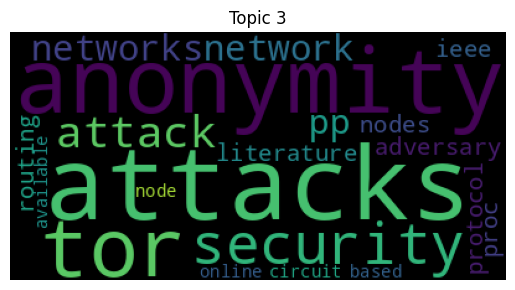

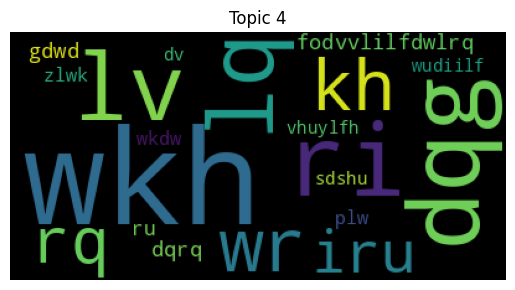

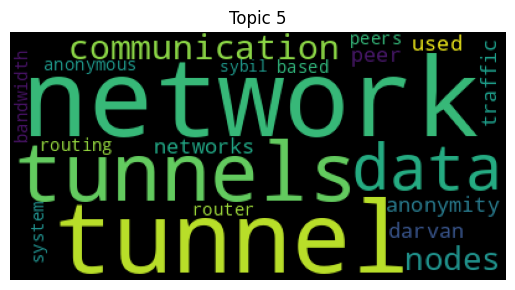

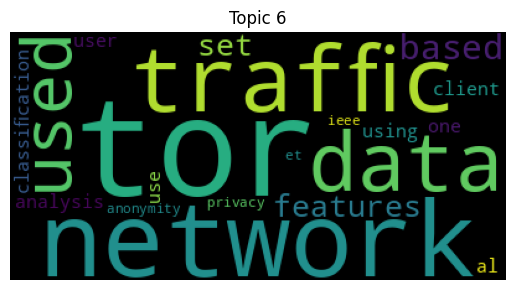

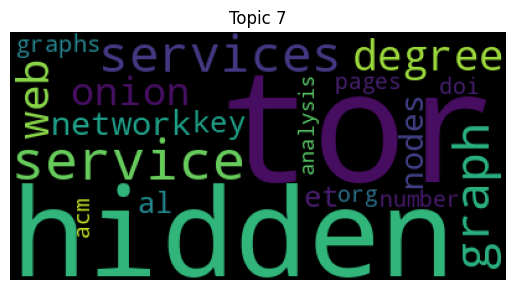

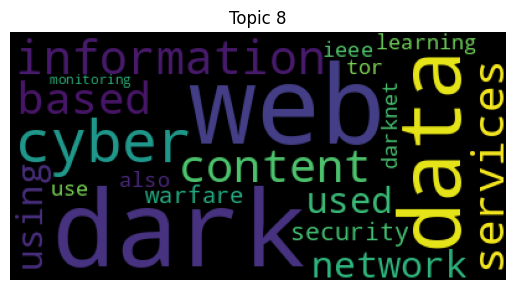

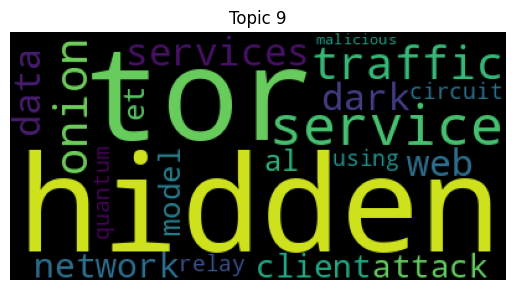

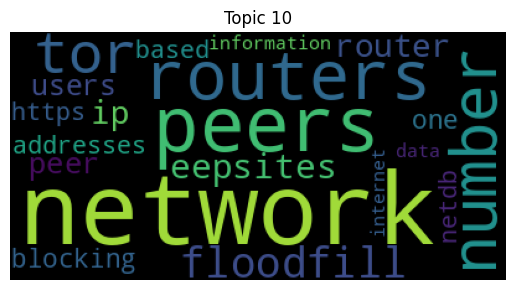

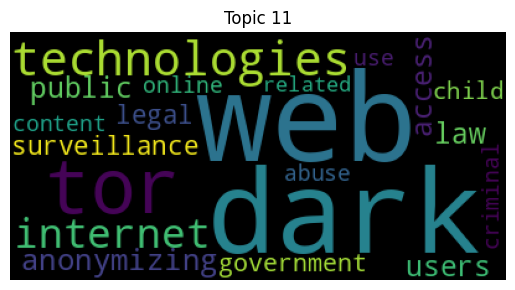

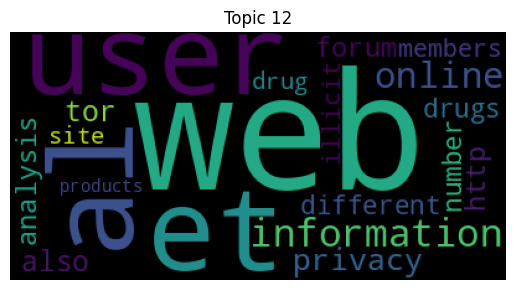

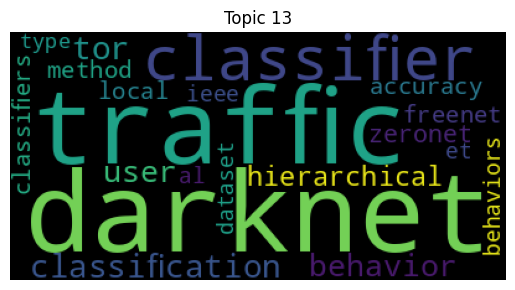

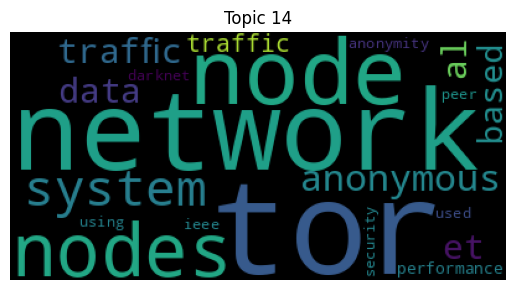

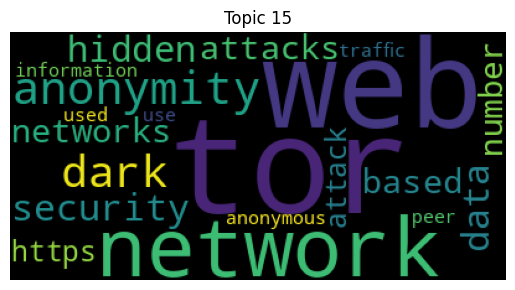

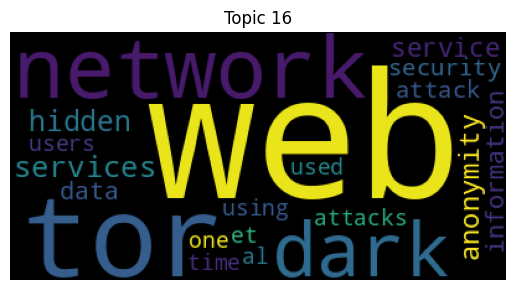

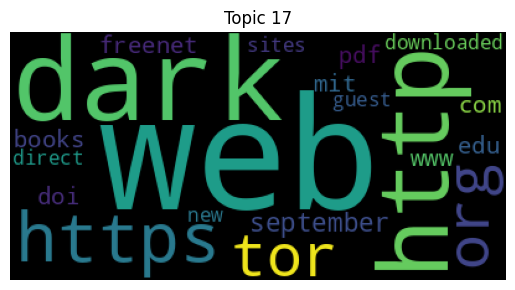

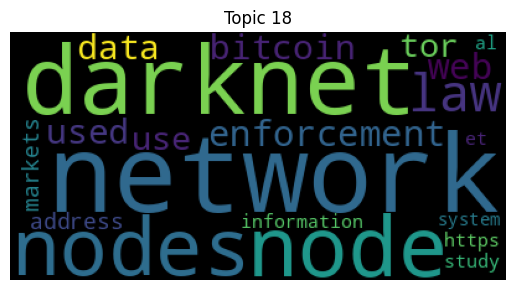

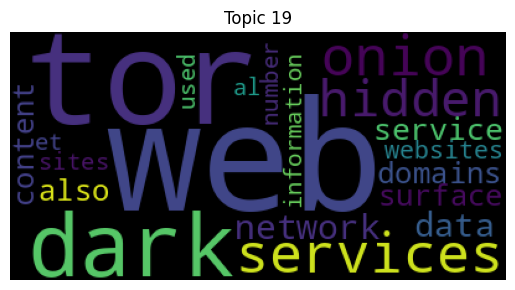

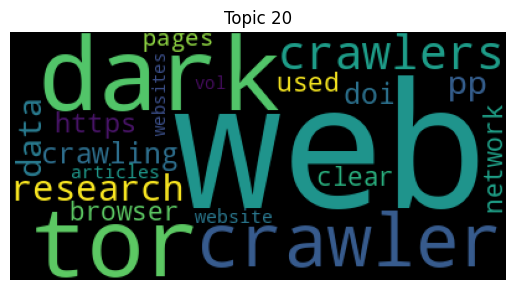

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each topic
for i in range(20):  # Adjust based on the number of topics
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(i, 20))))
    plt.title(f'Topic {i+1}')
    plt.axis("off")
    plt.show()


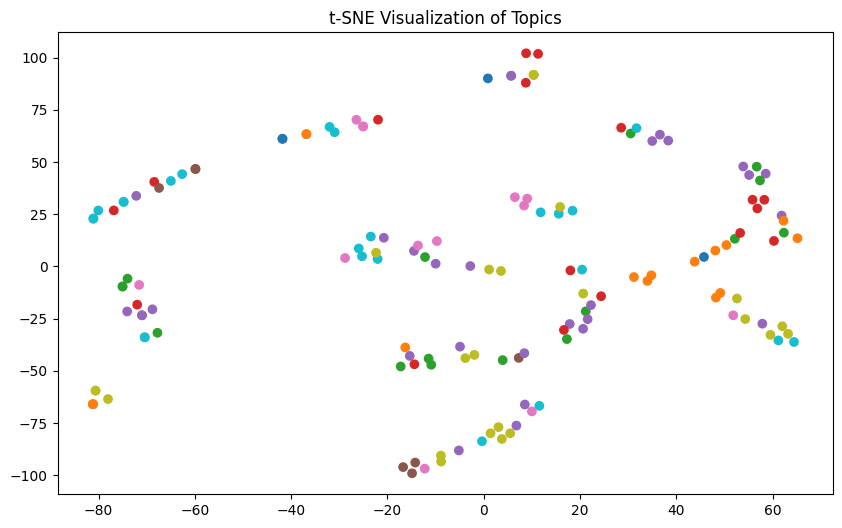

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

# Get topic proportions for t-SNE
topic_weights = []
for doc in corpus:
    doc_topic_weights = [w for _, w in lda_model.get_document_topics(doc)]
    # Pad or truncate to ensure a fixed size (20 topics)
    doc_topic_weights += [0] * (20 - len(doc_topic_weights))
    topic_weights.append(doc_topic_weights)

# Convert list of topic weights to a NumPy array
topic_weights_array = np.array(topic_weights)

# Perform t-SNE
tsne_model = TSNE(n_components=2, random_state=0, perplexity=5)
tsne_lda = tsne_model.fit_transform(topic_weights_array)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(tsne_lda, columns=['x', 'y'])
tsne_df['topic'] = [max(doc, key=lambda x: x[1])[0] for doc in lda_model.get_document_topics(corpus)]

# Plot t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df['x'], tsne_df['y'], c=tsne_df['topic'], cmap='tab10')
plt.title('t-SNE Visualization of Topics')
plt.show()


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the pyLDAvis visualization
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis_data)

# Optionally save the visualization as an HTML file
pyLDAvis.save_html(vis_data, '/content/drive/MyDrive/Mapping I2P/lda_visualization.html')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


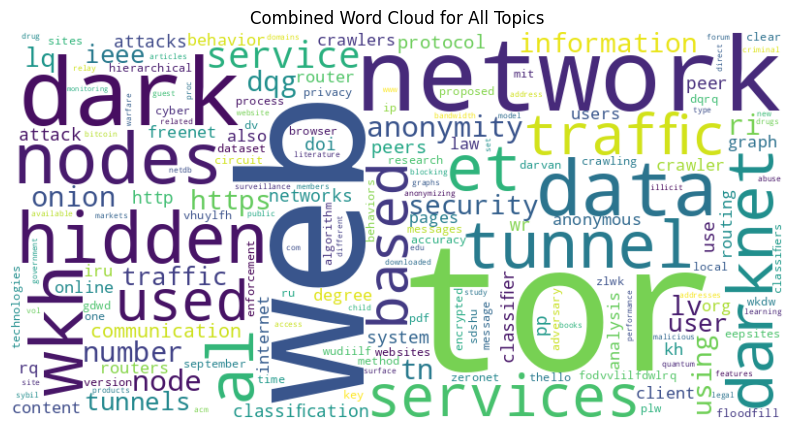

In [ ]:
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine words from all topics into one word frequency dictionary
combined_word_freq = defaultdict(float)

# Iterate over each topic
for i in range(20):  # Adjust based on the number of topics
    topic_words = lda_model.show_topic(i, 20)  # 20 most relevant words for each topic
    for word, weight in topic_words:
        combined_word_freq[word] += weight

# Generate a combined word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(combined_word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Combined Word Cloud for All Topics')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


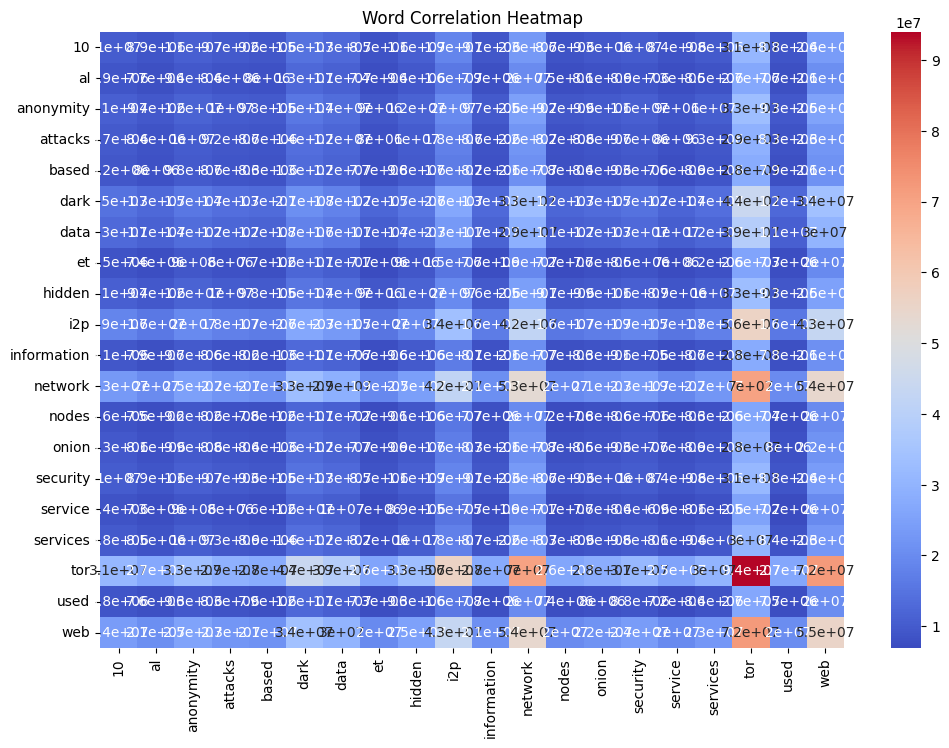

In [ ]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Combine all the text from the PDFs into one string
combined_text = ' '.join(pdf_texts)

# Tokenize and create a word frequency matrix
vectorizer = CountVectorizer(max_features=20, stop_words='english')  # Adjust number of features
X = vectorizer.fit_transform([combined_text])

# Get the word list
words = vectorizer.get_feature_names_out()

# Compute correlation matrix (co-occurrence)
correlation_matrix = (X.T @ X).toarray()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, xticklabels=words, yticklabels=words, cmap='coolwarm')
plt.title('Word Correlation Heatmap')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


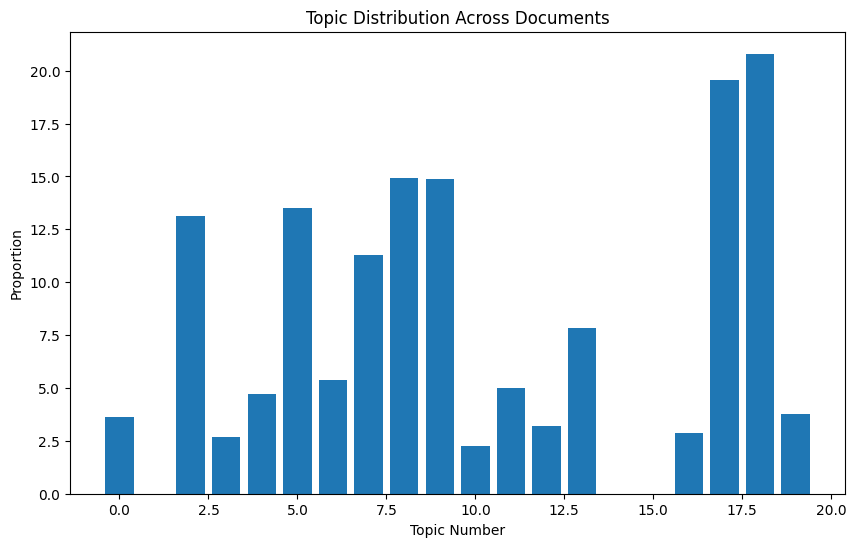

In [ ]:
import numpy as np

# Get topic distribution for each document
doc_topics = [lda_model.get_document_topics(doc) for doc in corpus]

# Initialize an array to accumulate topic distributions
topic_distribution = np.zeros(20)  # Adjust based on the number of topics

# Accumulate topic proportions for each document
for doc in doc_topics:
    for topic_num, proportion in doc:
        topic_distribution[topic_num] += proportion

# Plot the topic distribution as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(20), topic_distribution)
plt.xlabel('Topic Number')
plt.ylabel('Proportion')
plt.title('Topic Distribution Across Documents')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


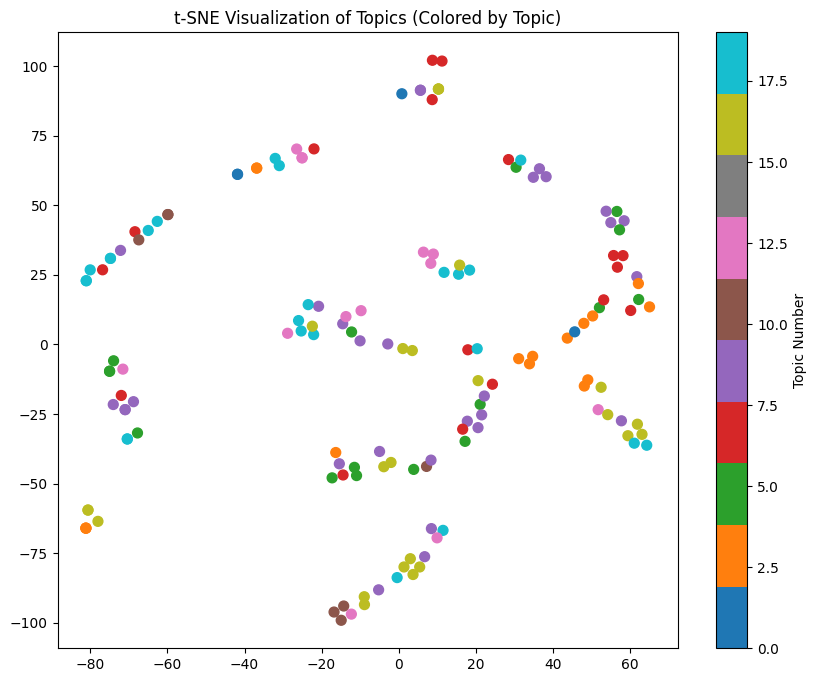

In [ ]:
from sklearn.manifold import TSNE

# Perform t-SNE on topic proportions
tsne_model = TSNE(n_components=2, random_state=0, perplexity=5)
tsne_lda = tsne_model.fit_transform(topic_weights_array)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(tsne_lda, columns=['x', 'y'])
tsne_df['topic'] = [max(doc, key=lambda x: x[1])[0] for doc in lda_model.get_document_topics(corpus)]

# Plot t-SNE with color labels for topics
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['x'], tsne_df['y'], c=tsne_df['topic'], cmap='tab10', s=50)
plt.colorbar(scatter, label="Topic Number")
plt.title('t-SNE Visualization of Topics (Colored by Topic)')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


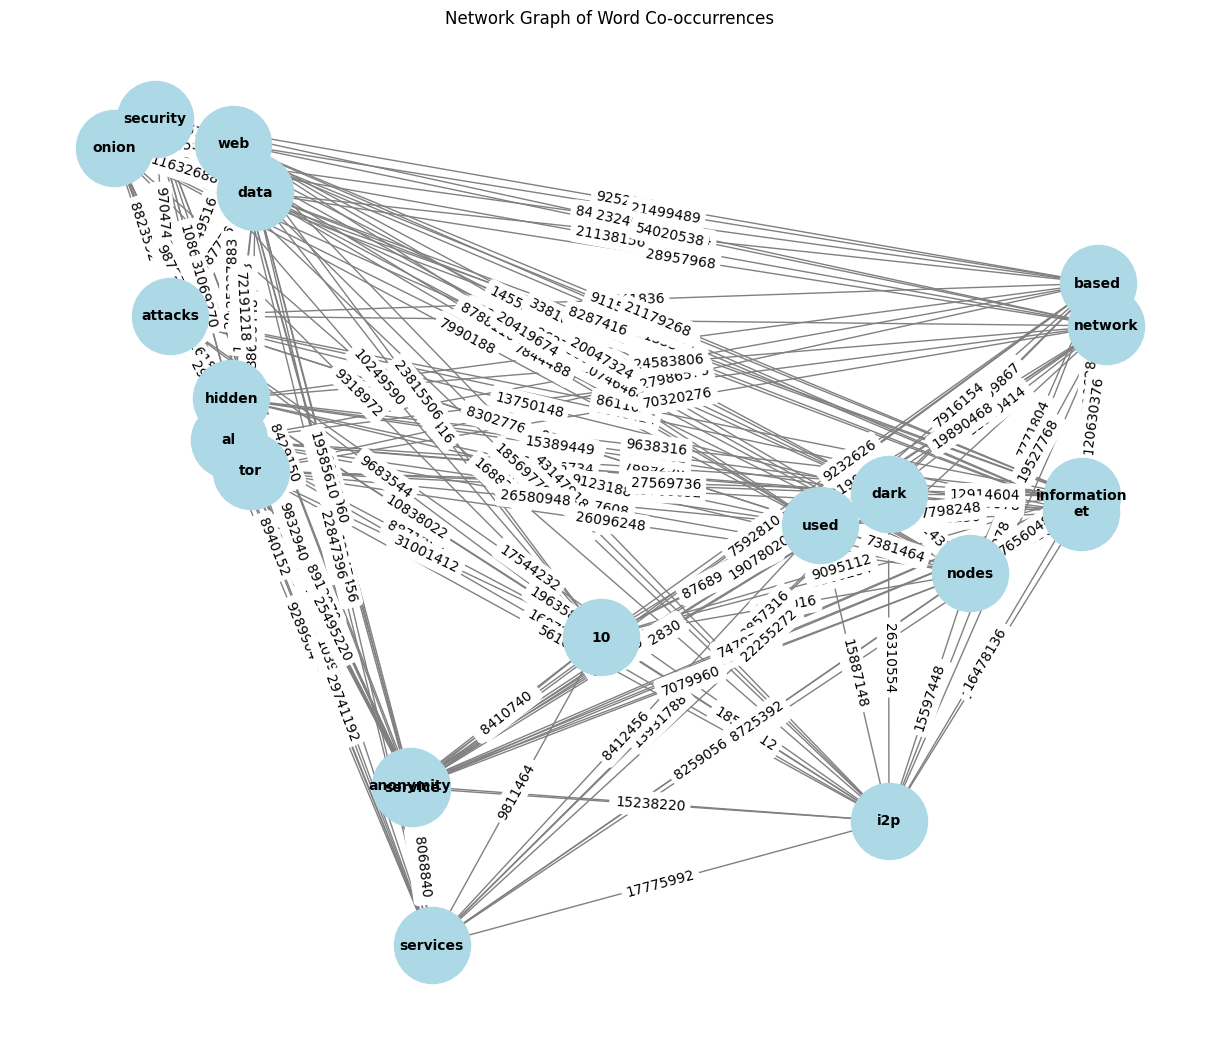

In [ ]:
import networkx as nx

# Create a NetworkX graph
G = nx.Graph()

# Add edges between words based on co-occurrence frequency
for i in range(len(words)):
    for j in range(i + 1, len(words)):
        if correlation_matrix[i, j] > 0:  # Only add edges for words that co-occur
            G.add_edge(words[i], words[j], weight=correlation_matrix[i, j])

# Draw the network graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Network Graph of Word Co-occurrences')
plt.show()


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the pyLDAvis visualization
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis_data)

# Optionally save as an HTML file for further exploration
pyLDAvis.save_html(vis_data, '/content/drive/MyDrive/Mapping I2P/lda_visualization_combined.html')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


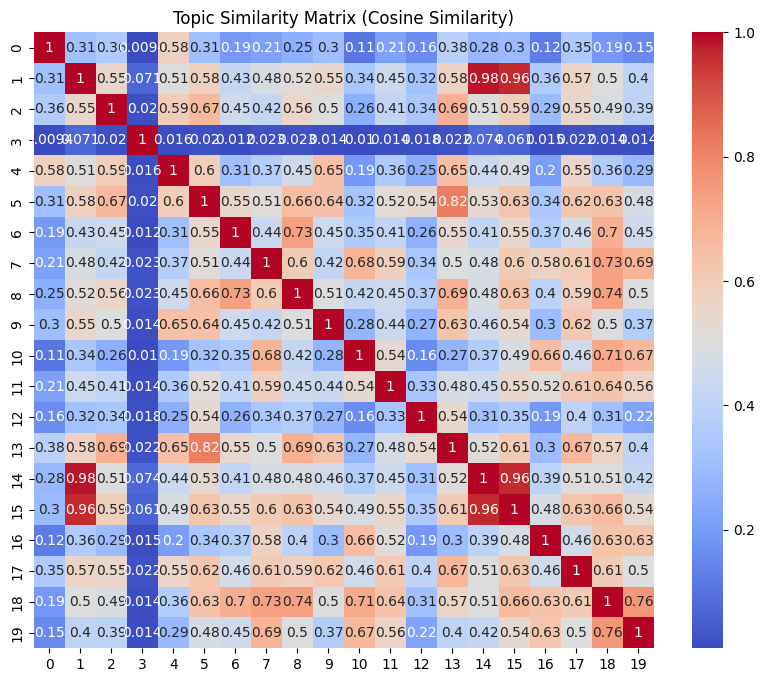

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Get the topic-word distributions
topic_word_distributions = lda_model.get_topics()

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(topic_word_distributions)

# Plot the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
plt.title('Topic Similarity Matrix (Cosine Similarity)')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


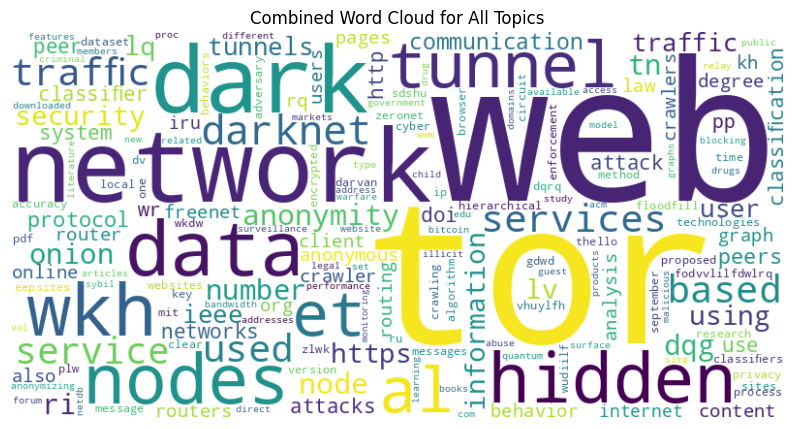

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict

# Combine words from all topics into one frequency dictionary
combined_word_freq = defaultdict(float)

for i in range(20):  # Adjust based on the number of topics
    topic_words = lda_model.show_topic(i, 20)
    for word, weight in topic_words:
        combined_word_freq[word] += weight

# Generate and save the combined word cloud as a PDF
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(combined_word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Combined Word Cloud for All Topics')

# Save the word cloud to Google Drive
plt.savefig('/content/drive/MyDrive/Mapping I2P/combined_wordcloud.pdf', format='pdf')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


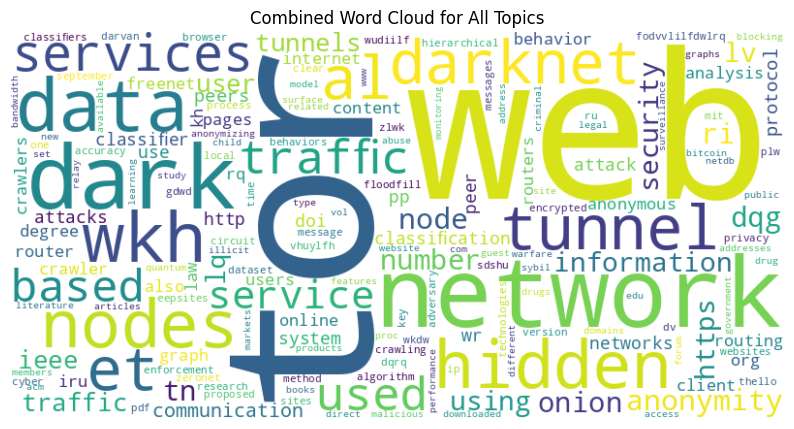

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict

# Combine words from all topics into one frequency dictionary
combined_word_freq = defaultdict(float)

for i in range(20):  # Adjust based on the number of topics
    topic_words = lda_model.show_topic(i, 20)
    for word, weight in topic_words:
        combined_word_freq[word] += weight

# Generate and save the combined word cloud as a PDF
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(combined_word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Combined Word Cloud for All Topics')

# Save the word cloud to the specified directory
plt.savefig('/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/visualizations/combined_wordcloud.pdf', format='pdf')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


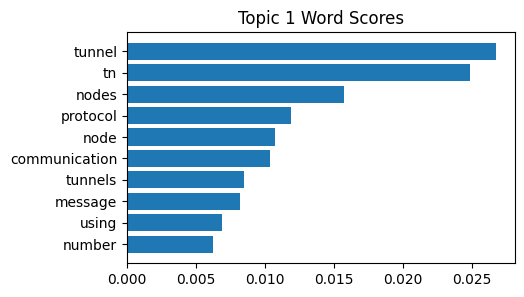

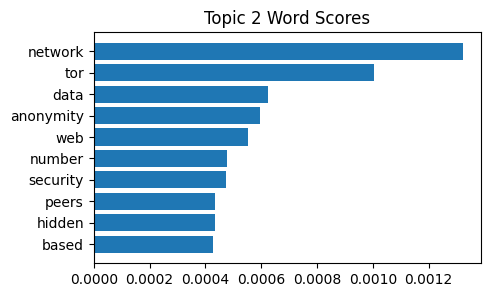

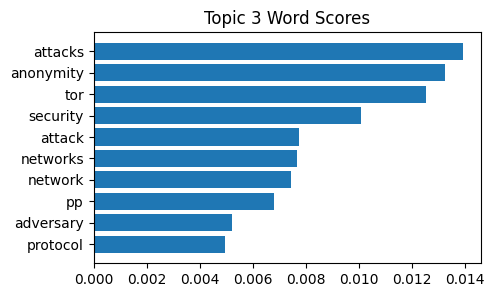

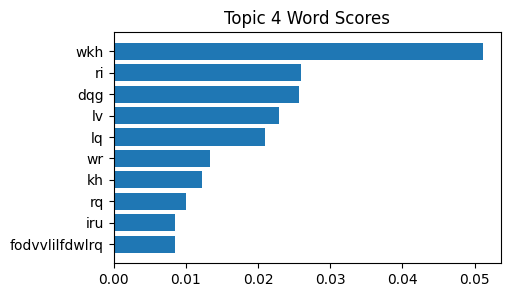

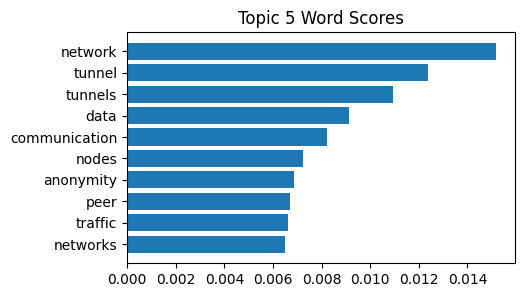

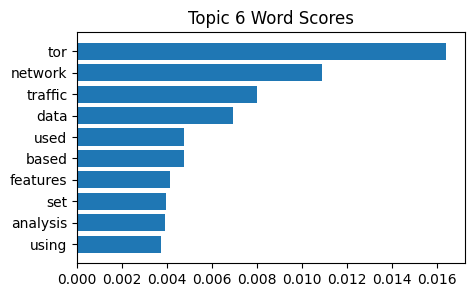

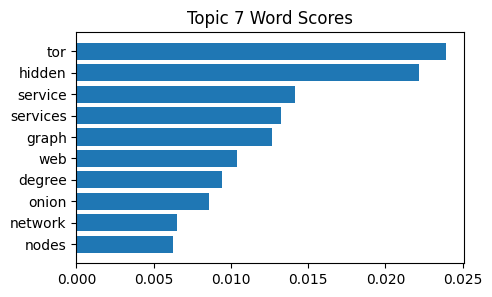

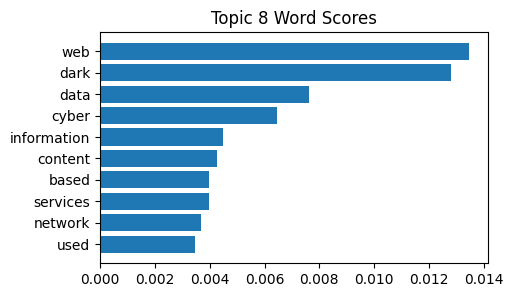

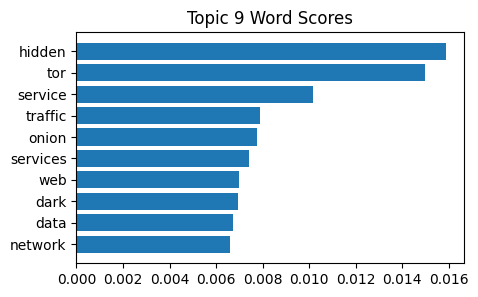

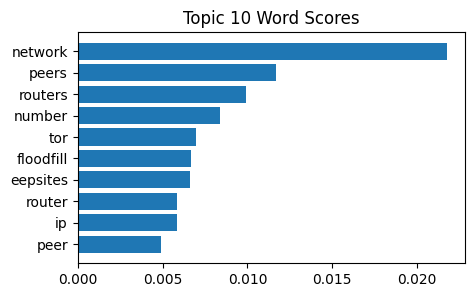

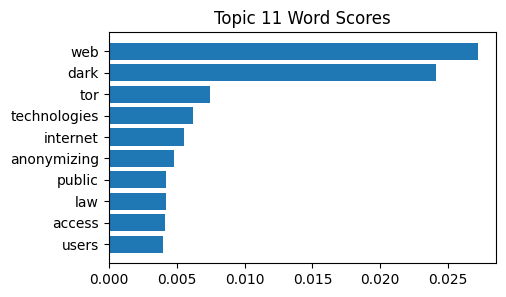

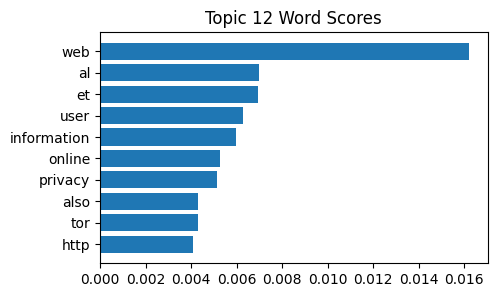

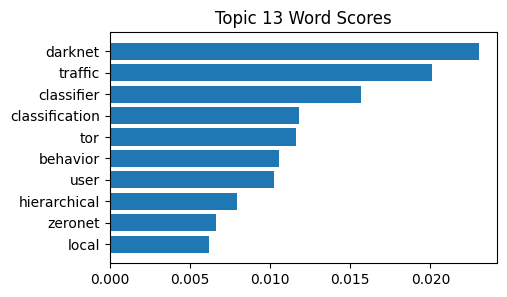

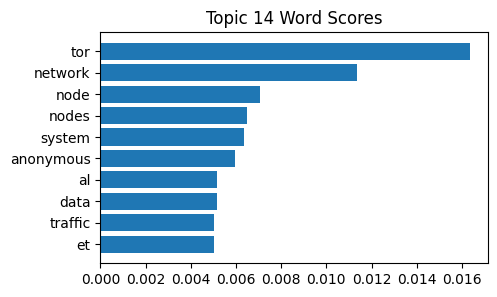

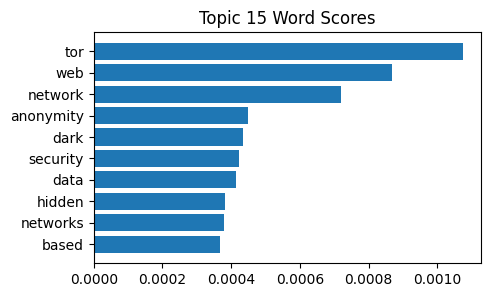

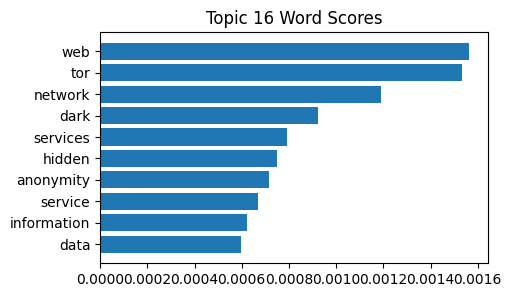

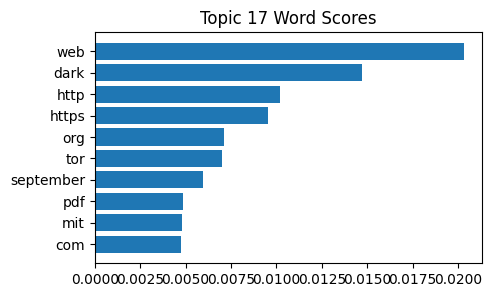

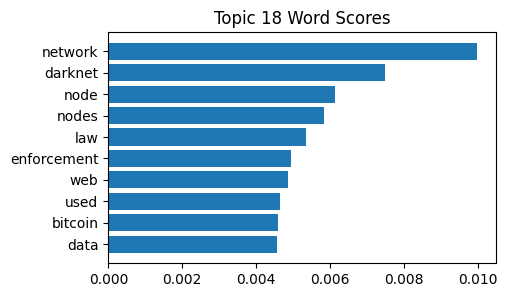

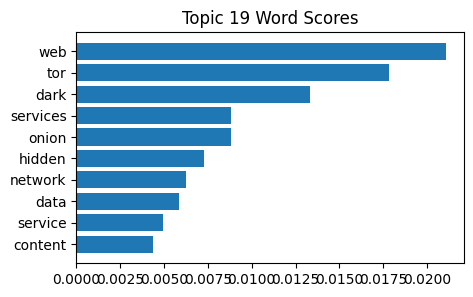

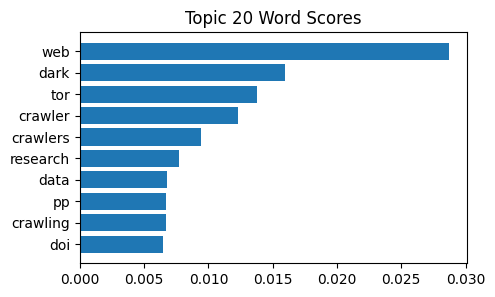

In [ ]:
import matplotlib.pyplot as plt

# Create the Topic Word Scores visualization and save it as a PDF
for i in range(20):  # Adjust based on the number of topics
    plt.figure(figsize=(5, 3))
    topic_words = lda_model.show_topic(i, 10)  # Display top 10 words per topic
    words, weights = zip(*topic_words)
    plt.barh(words, weights)
    plt.title(f'Topic {i+1} Word Scores')
    plt.gca().invert_yaxis()

    # Save each topic word score graph as a separate PDF file in the specified directory
    plt.savefig(f'/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/visualizations/topic_{i+1}_word_scores.pdf', format='pdf')
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-21-930e9b299eb8>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 20)


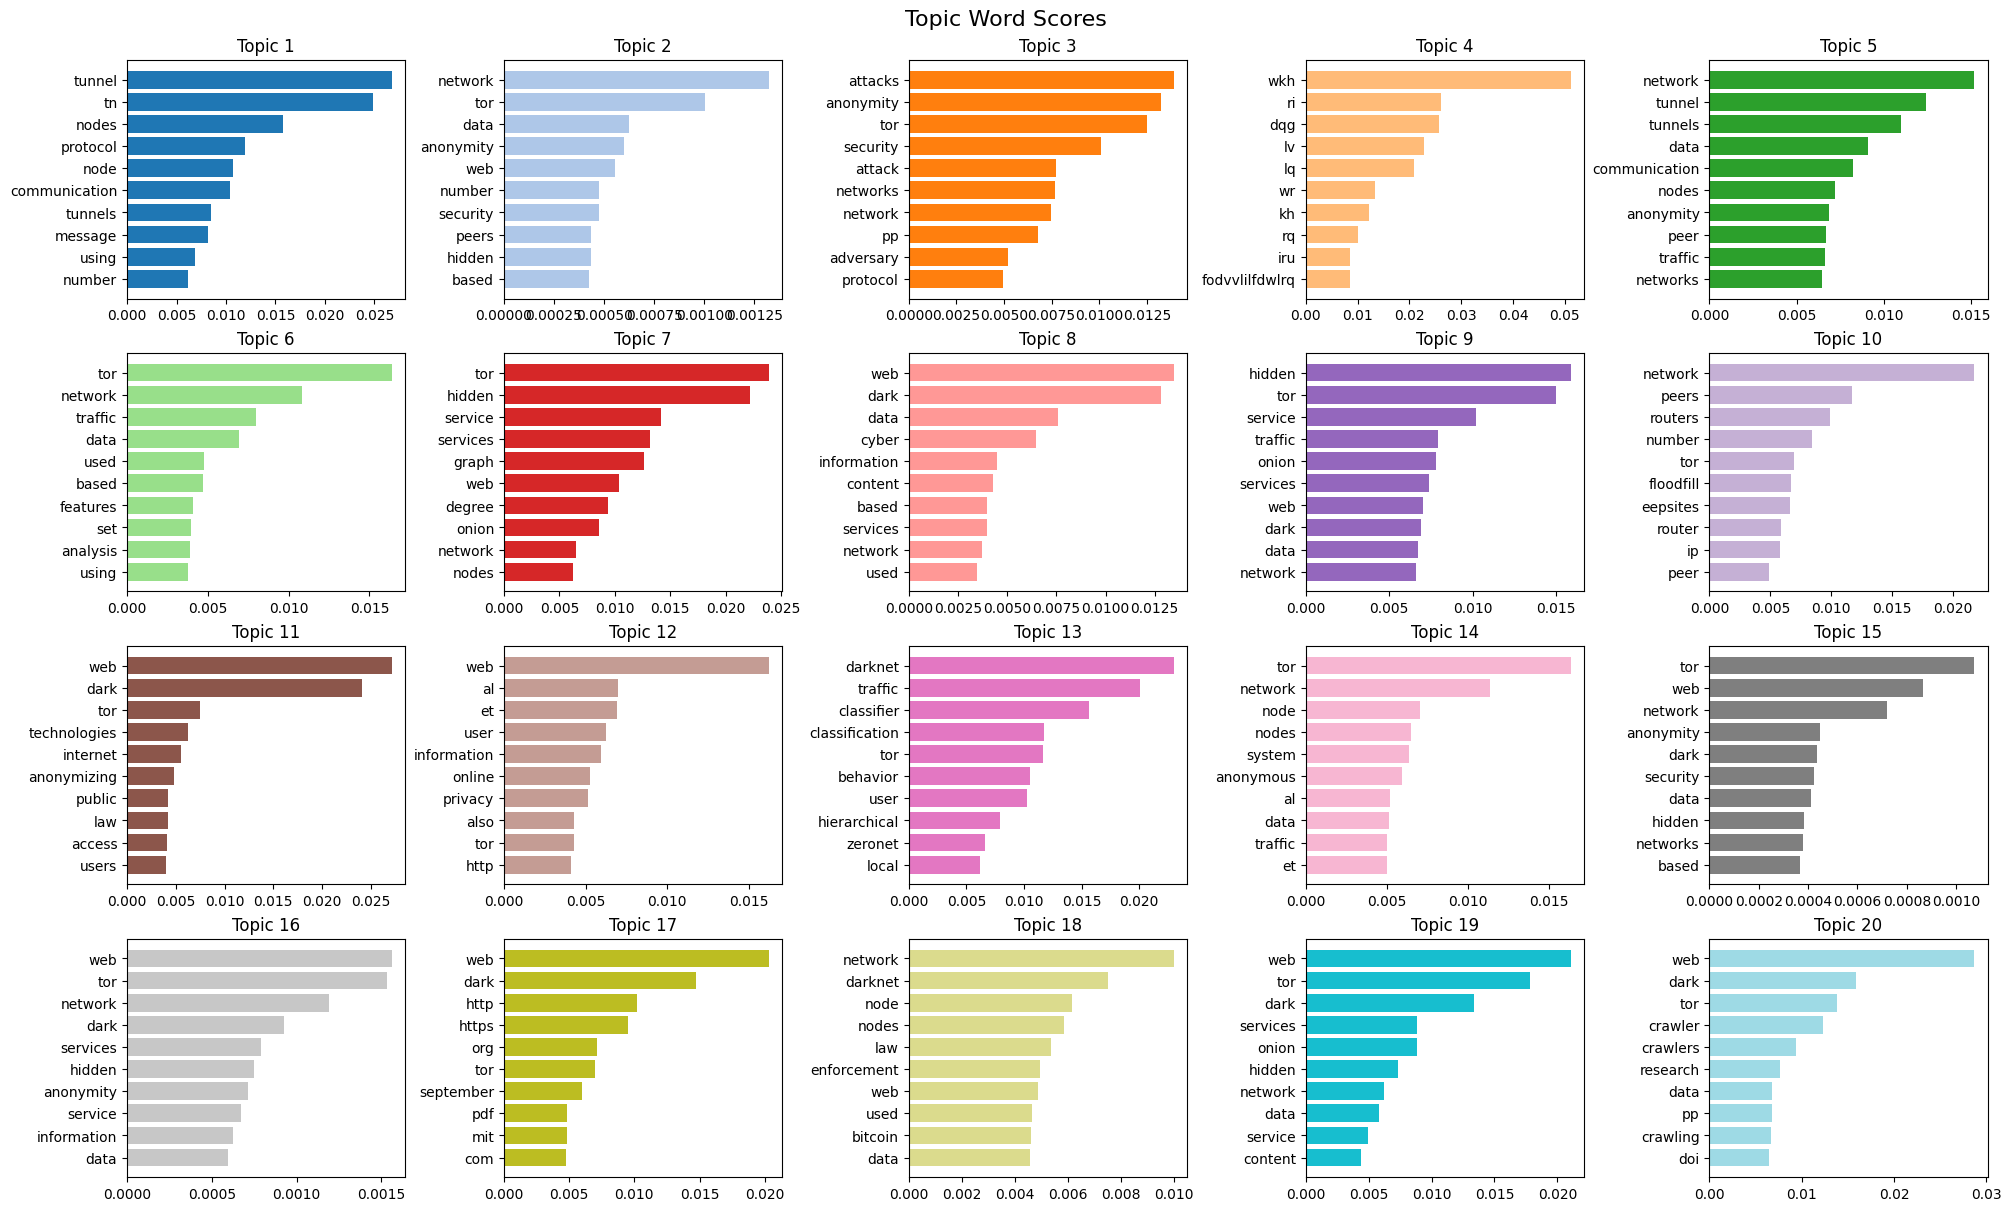

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for different topics
colors = plt.cm.get_cmap('tab20', 20)

# Create subplots (4 rows x 5 columns) to display all topics on a single page
fig, axes = plt.subplots(4, 5, figsize=(20, 12), constrained_layout=True)

# Loop through each topic and create a bar chart for each
for i, ax in enumerate(axes.flatten()):
    if i < 20:  # Adjust based on the number of topics
        topic_words = lda_model.show_topic(i, 10)  # Top 10 words for each topic
        words, weights = zip(*topic_words)

        # Create horizontal bar plot for the topic word scores
        ax.barh(words, weights, color=colors(i))
        ax.set_title(f'Topic {i+1}')
        ax.invert_yaxis()

# Set the main title and save the combined plot as a single PDF
fig.suptitle('Topic Word Scores', fontsize=16)
plt.savefig('/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/visualizations/combined_topic_word_scores.pdf', format='pdf')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


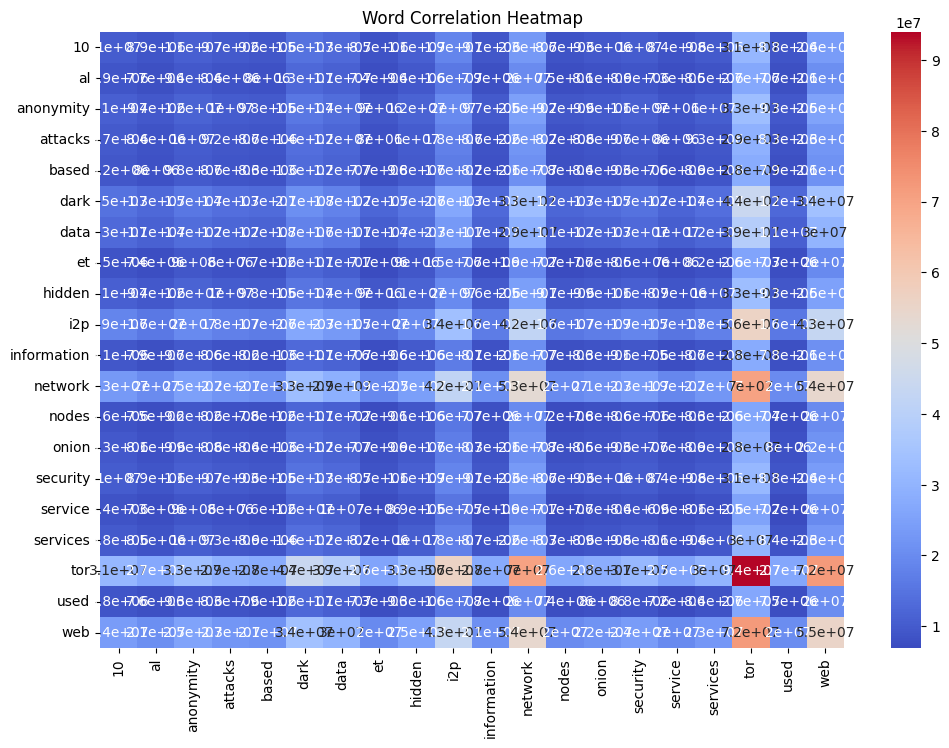

In [ ]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Create a word frequency matrix for the correlation heatmap
vectorizer = CountVectorizer(max_features=20, stop_words='english')
X = vectorizer.fit_transform([' '.join(pdf_texts)])
words = vectorizer.get_feature_names_out()
correlation_matrix = (X.T @ X).toarray()

# Plot and save the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, xticklabels=words, yticklabels=words, cmap='coolwarm')
plt.title('Word Correlation Heatmap')

# Save the heatmap as a PDF
plt.savefig('/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/visualizations/word_correlation_heatmap.pdf', format='pdf')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


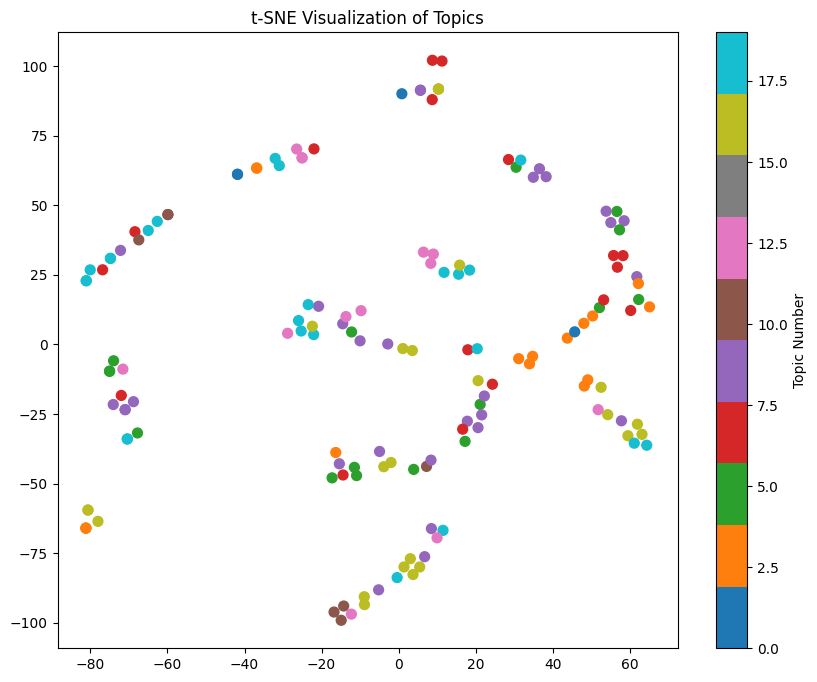

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

# Perform t-SNE and visualize topic clusters
tsne_model = TSNE(n_components=2, random_state=0, perplexity=5)
tsne_lda = tsne_model.fit_transform(topic_weights_array)

# Create DataFrame for plotting
tsne_df = pd.DataFrame(tsne_lda, columns=['x', 'y'])
tsne_df['topic'] = [max(doc, key=lambda x: x[1])[0] for doc in lda_model.get_document_topics(corpus)]

# Plot and save t-SNE plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['x'], tsne_df['y'], c=tsne_df['topic'], cmap='tab10', s=50)
plt.colorbar(scatter, label="Topic Number")
plt.title('t-SNE Visualization of Topics')

# Save the t-SNE visualization as a PDF
plt.savefig('/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/visualizations/tsne_topics.pdf', format='pdf')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


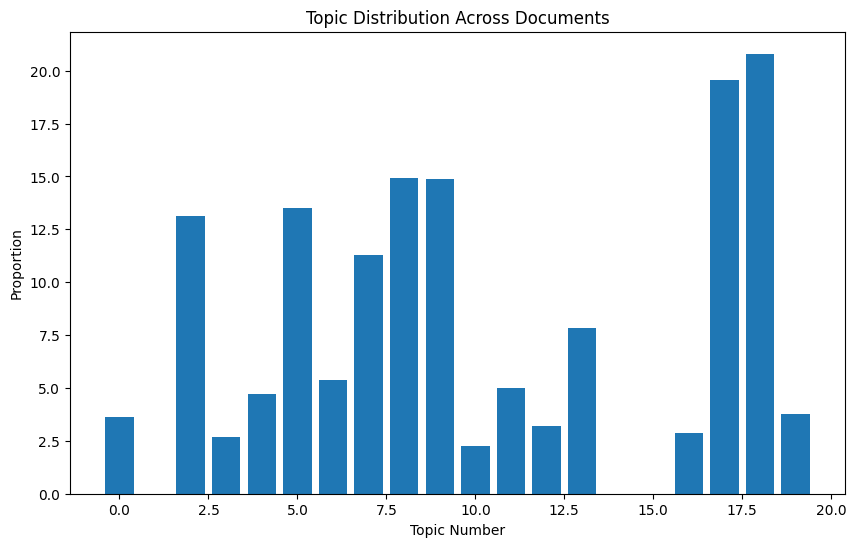

In [ ]:
# Plot and save the topic distribution across documents
plt.figure(figsize=(10, 6))
plt.bar(range(20), topic_distribution)
plt.xlabel('Topic Number')
plt.ylabel('Proportion')
plt.title('Topic Distribution Across Documents')

# Save the bar chart as a PDF
plt.savefig('/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/visualizations/topic_distribution.pdf', format='pdf')
plt.show()


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare PyLDAvis visualization
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Save the PyLDAvis visualization as an HTML file
pyLDAvis.save_html(vis_data, '/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/visualizations/lda_visualization.html')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


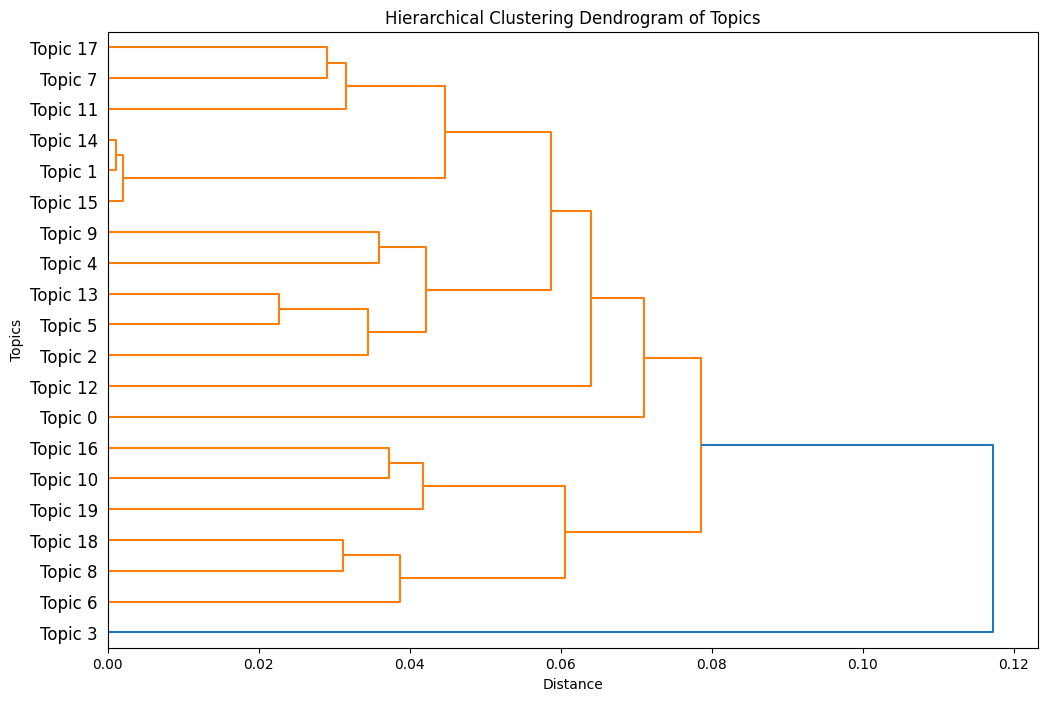

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Create a linkage matrix for hierarchical clustering using the topic-word distributions
linkage_matrix = linkage(topic_word_distributions, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, orientation='right', labels=[f'Topic {i}' for i in range(20)])
plt.title('Hierarchical Clustering Dendrogram of Topics')
plt.xlabel('Distance')
plt.ylabel('Topics')

# Save the dendrogram as a PDF
plt.savefig('/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/visualizations/topic_dendrogram.pdf', format='pdf')
plt.show()


In [ ]:
import seaborn as sns
import pandas as pd

# Create a pairwise correlation dataframe using the topic-word distributions
topic_df = pd.DataFrame(topic_word_distributions)
correlation_matrix = topic_df.corr()

# Create a pairplot for the correlations
sns.pairplot(correlation_matrix)
plt.title('Pairwise Topic Correlation Plot')

# Save the pairwise correlation plot as a PDF
plt.savefig('/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/visualizations/pairwise_topic_correlation.pdf', format='pdf')
plt.show()


NameError: name 'topic_word_distributions' is not defined

In [ ]:
import numpy as np

# Create a matrix of word frequencies per topic
topic_word_matrix = np.zeros((len(words), 20))  # Assuming 20 topics and top N words
for i in range(20):  # Loop over each topic
    topic_words = lda_model.show_topic(i, len(words))
    for word, weight in topic_words:
        if word in words:
            word_idx = list(words).index(word)
            topic_word_matrix[word_idx, i] = weight

# Plot the word frequency heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topic_word_matrix, xticklabels=[f'Topic {i+1}' for i in range(20)], yticklabels=words, cmap='Blues')
plt.title('Heatmap of Word Frequencies Across Topics')

# Save the heatmap as a PDF
plt.savefig('/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/visualizations/word_frequency_heatmap.pdf', format='pdf')
plt.show()


NameError: name 'words' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install transformers PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
import PyPDF2

# Path to the folder containing your PDF files
pdf_folder_path = '/content/drive/MyDrive/Mapping I2P/LLM-GPTneo_and_FLAN/'

def extract_text_from_pdfs(pdf_folder_path):
    pdf_texts = []

    # Loop through all files in the directory
    for filename in os.listdir(pdf_folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(pdf_folder_path, filename)
            with open(file_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                text = ''
                for page in range(len(reader.pages)):
                    text += reader.pages[page].extract_text()
                pdf_texts.append(text)

    return pdf_texts

# Extract text from all PDFs in the folder
pdf_texts = extract_text_from_pdfs(pdf_folder_path)
